In [1]:
# this is an input-output file, which takes the fits file as an input and gives us a white image of the data cube by suming all the values of the wavelength axis
# importing the required libraries
from musetools import io as io
import matplotlib.pyplot as plt
from musetools import spec as s
import numpy as np
import getpass
from astropy.convolution import Gaussian2DKernel, convolve
from matplotlib import mlab, cm

from copy import deepcopy

%matplotlib inline
username=getpass.getuser()

if username == 'bordoloi':
	fitsfile = '/Users/bordoloi/Dropbox/MUSE/LensedArc/RCS0327_16mc_zap.fits'
else:
	fitsfile = '/home/ahmed/astro/data/RCS0327_16mc_zap.fits'
#input("Enter the path to your file: ")


wave, data, var, header = io.open_muse_cube(fitsfile)
#w = WCS(header)
zgal= 1.7037455
wrest = wave/(1.+zgal)

#spec, spec_err = s.extract_square(115, 237, wave, data, var, 5)
minwave = 7558.4#7090.     #7090.       #7555.
maxwave = 7563.7#7110.     #7110.       #7573.
ems_image = io.narrow_band(minwave, maxwave, wave, data,plot=False)
cont_min = 7645.#6930.
cont_max = 7650.3#6950.
cont_image = io.narrow_band(cont_min, cont_max, wave, data,plot=False)


wl_min = 6500.#6930.
wl_max = 8500.5#6950.
wl_image = io.narrow_band(wl_min, wl_max, wave, data,plot=False)


residual_image=ems_image-cont_image

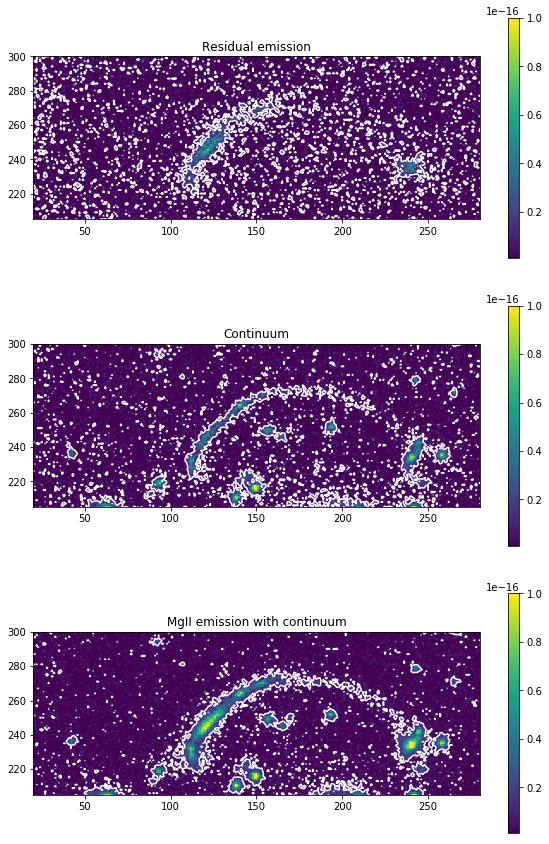

In [9]:

'''
The z stretching for the color map
'''

zmin=1e-18
zmax=1e-16

width_in = 10
fig=plt.figure(1, figsize=(width_in, 15))
ax = fig.add_subplot(311)
im = ax.imshow( residual_image, cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
ax.contour(residual_image,levels=[1e-17],colors='white')
fig.colorbar(im)
ax.set_title('Residual emission')
ax.set_ylim([205,300])
ax.set_xlim([20,280])


ax1 = fig.add_subplot(312)
im1 = ax1.imshow(cont_image, cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
ax1.contour(cont_image,levels=[1e-17],colors='white')
fig.colorbar(im1)
ax1.set_title('Continuum')
ax1.set_ylim([205,300])
ax1.set_xlim([20,280])



ax2 = fig.add_subplot(313)
im2 = ax2.imshow(ems_image, cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
ax2.contour(ems_image,levels=[1e-17],colors='white')
fig.colorbar(im2)
ax2.set_title('MgII emission with continuum')
ax2.set_ylim([205,300])
ax2.set_xlim([20,280])

plt.show()


In [21]:
# We smooth with a Gaussian kernel with stddev=2
# It is a 9x9 array
kernel = Gaussian2DKernel(x_stddev=1.4)
# create a "fixed" image with NaNs replaced by interpolated values
# astropy's convolution replaces the NaN pixels with a kernel-weighted
# interpolation from their neighbors
astropy_conv = convolve(residual_image, kernel)
mean_val=(np.mean(astropy_conv))
std_val=(np.std(astropy_conv))

sig_threshold=3.
qq=np.where((astropy_conv < sig_threshold*std_val))
qq_complement=np.where((astropy_conv >= sig_threshold*std_val))


ROI=deepcopy(residual_image)

ROI[qq]= 0.

#Now create a mask 
Mask=deepcopy(astropy_conv)
Mask[qq_complement]=1.
Mask[qq]=0.

Final_Image=1.+ROI*Mask

$\textbf{Now Start the actual ROI finding}$

In [10]:
def smooth_image(image,stddev=1.4,sig_threshold=3.,sky_x=[240,280],sky_y=[40,100]):
    #-----------------------------------------------
    # This is a quick wrapper to compute a region of interest of certain emission strength. 
    # 
    # Input:- 
    #        image = image matrix
    #        stddev = standard deviation of the smoothing Gaussian kernel
    #        sig_threshold  = sigma threshold above which emission is detected
    #        sky_x, sky_y =  x,y coordinates to chose the background space. 
    #
    # Output:- 
    #        Final_Image =  Image with region of interest, every other pixel value = 0
    #
    #------------------------------------------------
    
    # We smooth with a Gaussian kernel with stddev=2
    # It is a 9x9 array
    if stddev >0:
        kernel = Gaussian2DKernel(x_stddev=stddev)
        # create a "fixed" image with NaNs replaced by interpolated values
        # astropy's convolution replaces the NaN pixels with a kernel-weighted
        # interpolation from their neighbors
        astropy_conv = convolve(image, kernel)
    else:
        astropy_conv =image
            

        
    mean_val=(np.mean(astropy_conv))
    std_val=(np.std(astropy_conv[sky_x[0]:sky_x[1],sky_y[0]:sky_y[1]]))
    
    qq=np.where((astropy_conv < sig_threshold*std_val))
    qq_complement=np.where((astropy_conv >= sig_threshold*std_val))
    ROI=deepcopy(astropy_conv)
    ROI[qq]= 0.
    #Now create a mask 
    Mask=deepcopy(astropy_conv)
    Mask[qq_complement]=1.
    Mask[qq]=0.
    
    return ROI*Mask

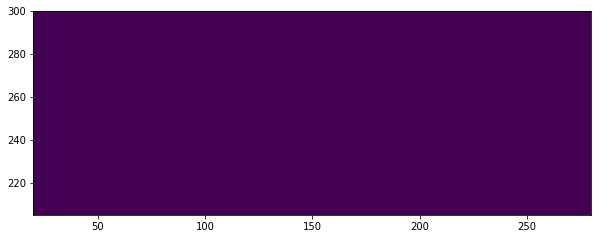

In [13]:


Final_Image=smooth_image(ems_image,stddev=1.4,sig_threshold=3.,sky_x=[260,280],sky_y=[40,100])
Final_Image1=smooth_image(cont_image,stddev=1.4,sig_threshold=3.,sky_x=[260,280],sky_y=[40,100])

Final_Image= Final_Image+1.

ydim, xdim = Final_Image.shape

zmin=1e-18
zmax=1e-16

x = np.arange(0., xdim, 1.)
y = np.arange(0., ydim, 1.)
X, Y = np.meshgrid(x, y)
levels = 0.+np.arange(1e-18, 1e-16, 10)  # Boost the upper limit to avoid truncation errors.
norm = cm.colors.Normalize(vmax=abs(Final_Image).max(), vmin=(Final_Image).min())

width_in = 10
fig=plt.figure( figsize=(width_in, 15))
ax = fig.add_subplot(111)

lbg=ax.imshow(Final_Image,cmap=plt.get_cmap('viridis'),origin="lower",vmin=zmin, vmax=zmax)
ax.set_ylim([205,300])
ax.set_xlim([20,280])



#CS = plt.contour(X, Y, lya_map,levels,norm=norm,cmap='plasma')
CS = plt.contour(X, Y, Final_Image,[1e-17],norm=norm,cmap='winter')

In [ ]:
from copy import deepcopy

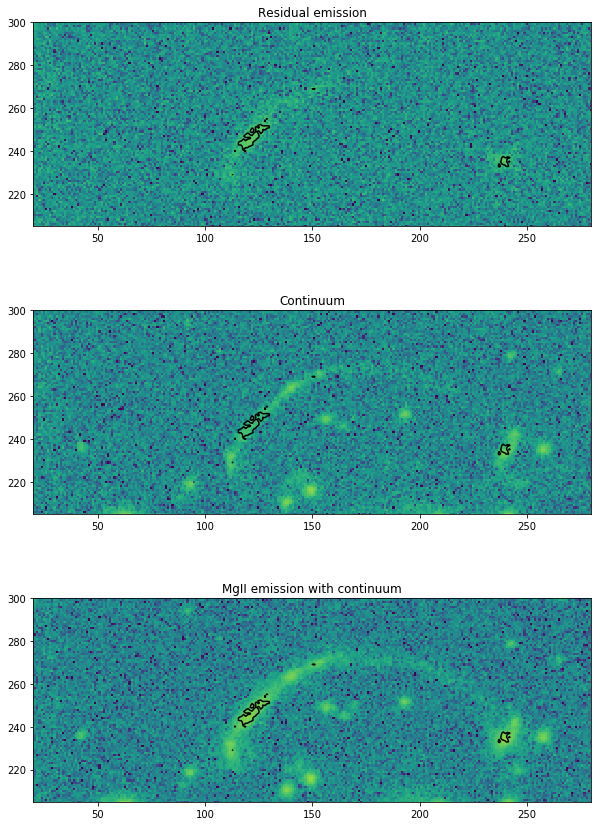

In [50]:
zmin=-2
zmax=2.

width_in = 10
fig=plt.figure(1, figsize=(width_in, 15))
ax = fig.add_subplot(311)
ax.imshow(np.log10(np.abs( residual_image)), cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
CS = plt.contour(X, Y, np.log10(np.abs(Final_Image)),[0.9,1.5,2.],norm=norm,cmap='magma')
ax.set_title('Residual emission')
ax.set_ylim([205,300])
ax.set_xlim([20,280])
'''
dat0 = CS.allsegs[0][0]
plt.plot(dat0[:,0],dat0[:,1],'r--')
print(dat0)
'''

ax1 = fig.add_subplot(312)
ax1.imshow(np.log10(np.abs(cont_image )), cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
CS = plt.contour(X, Y, np.log10(np.abs(Final_Image)),[0.9,1.5,2.],norm=norm,cmap='magma')

ax1.set_title('Continuum')
ax1.set_ylim([205,300])
ax1.set_xlim([20,280])



ax2 = fig.add_subplot(313)
ax2.imshow(np.log10(np.abs(ems_image)), cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
CS = plt.contour(X, Y, np.log10(np.abs(Final_Image)),[0.9,1.5,2.],norm=norm,cmap='magma')

ax2.set_title('MgII emission with continuum')
ax2.set_ylim([205,300])
ax2.set_xlim([20,280])

plt.show()